# Geometrical Methods in Machine Learning
## Seminar 5: Topological Data Analysis

In [1]:
!pip install --upgrade Cython
!pip install --upgrade Ripser
!pip install --upgrade persim
!pip install --upgrade diagram2vec
!pip install --upgrade giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.7 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.32
    Uninstalling Cython-0.29.32:
      Successfully uninstalled Cython-0.29.32
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 1.0 MB/s eta 0:00:00a 0:00:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl (13.9 MB)
  Created wheel for Ripser: filename=ripser-0.6.8-cp39-cp39-macosx_11_0_arm64.whl size=76859 sha256=d19712396b4e60198fe9100235c01cf17919fecf4fc1e4562d30dbbe2b5123b3
  Stored in directory: /Users/maxim/Library/Caches/pip/wheels/7b/18/f0/95bbfbb618317059bf946b16c960b2af01806bc14aab25c61d
Successfully built Ripser
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.1/712.1 kB 13.6 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install simplicial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 690.8 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for simplicial: filename=simplicial-1.0.1-py2.py3-none-any.whl size=55167 sha256=2710ea09d6f7580f4dd2a07ad525c253e8a5f8ad08c73292ba1cf56bb2041fa2
  Stored in directory: /Users/maxim/Library/Caches/pip/wheels/6e/95/78/8bb093452c3b3a28006f20d921f08ace5cf709f25358e9d4d2
Successfully built simplicial


In [3]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from ripser import lower_star_img
from ripser import Rips
vr = Rips()

import persim
import diagram2vec

from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_circles
from sklearn.manifold import MDS

import simplicial
import simplicial.drawing

import pickle
from tqdm import tqdm

import torch
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceImage, PersistenceEntropy

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


## 0. Simplicial complexes and homology

**Exercise**: create a simplicial complex consisting of 7 vertices and 6 edges

In [4]:
# create simplicial complex
cmplx = simplicial.SimplicialComplex()

In [5]:
# add 0-simplices (vertices)
v1 = cmplx.addSimplex(id="v1")
v2 = cmplx.addSimplex(id="v2")
v3 = cmplx.addSimplex(id="v3")
v4 = cmplx.addSimplex(id="v4")
v5 = cmplx.addSimplex(id="v5")
v6 = cmplx.addSimplex(id="v6")
v7 = cmplx.addSimplex(id="v7")

In [6]:
# add 1-simplices (edges)
cmplx.addSimplex(['v2', 'v3'], id="e1")
cmplx.addSimplex(['v4', 'v5'], id="e2")
cmplx.addSimplex(['v4', 'v6'], id="e3")
cmplx.addSimplex(['v5', 'v6'], id="e4")
cmplx.addSimplex(['v5', 'v7'], id="e5")
cmplx.addSimplex(['v6', 'v7'], id="e6")

'e6'

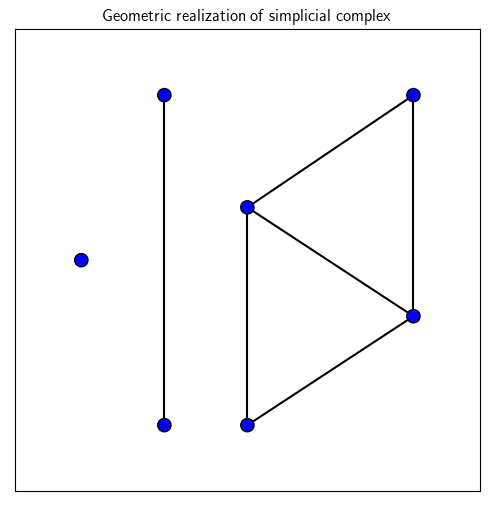

In [7]:
# set coordinates for vertices
em = simplicial.Embedding(cmplx)
em.positionSimplex(v1, (0.0, 0.5))

em.positionSimplex(v2, (0.25, 1.0))
em.positionSimplex(v3, (0.25, 0.0))

em.positionSimplex(v4, (1.0, 1.0))
em.positionSimplex(v5, (0.5, 0.66))
em.positionSimplex(v6, (1.0, 0.33))
em.positionSimplex(v7, (0.5, 0.0))

# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

### Betti numbers

_K-th Betti number_ of topological space is the rank of its' associated _k-th homological group_ and describes the number of holes of dimension $k+1$.

- 0-dimensional holes are connected components
- 1-dimensional holes are loops
- 2-dimensional holes are voids

**Exercise**

Evaluate the dimensionality and non-vanishing Betti numbers of a simplicial complex

In [8]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [9]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 1
Betti-0: 3
Betti-1: 2


### Modifying the topology of the simplicial complex

**Exercise**

Modify the topology of the simplicial complex by "filling" one of its' 2-dimensional holes by a 2-simplex which is a triangle.

In [10]:
# add 2-simplex (triangle)
cmplx.addSimplex(['e2', 'e3', 'e4'], id="t1")

't1'

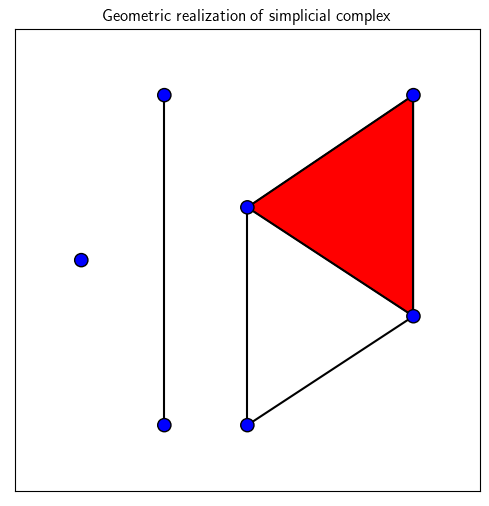

In [11]:
# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

In [12]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [13]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 2
Betti-0: 3
Betti-1: 1
Betti-2: 0


## 1. Persistent diagrams, Wasserstein distance and stability

In [14]:
# original data
X, y = make_circles(n_samples=200, noise=0.1)
X = X[y==0]

Topology studies data invariant to continous transformations, so topological invariants like (persistent) homology will not change under such class of transformations.

**Exercise**

Apply rotation and dilation transformations to copy of original data.

In [15]:
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R)

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


In [16]:
# transformed data
X_transformed = np.copy(X)
X_transformed[:,0] = X[:,0] * 0.75
X_transformed = np.dot(X_transformed, R)

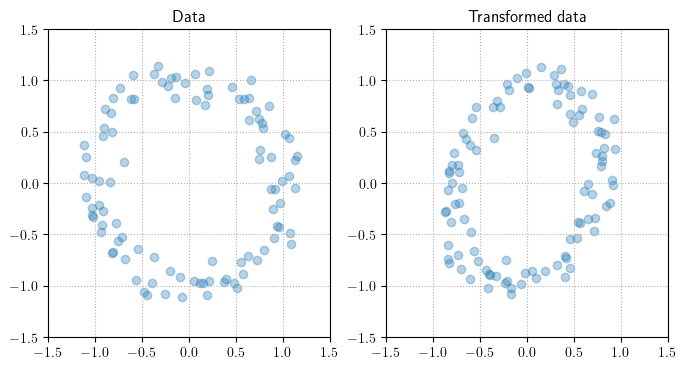

In [17]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X[:,0], X[:,1], alpha=0.33)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X_transformed[:,0], X_transformed[:,1], alpha=0.33)

plt.show()

**Exercise**

Compute persistence diagrams of a filtration of Vietoris-Rips complex built on point cloud data

In [18]:
diagram = vr.fit_transform(X)
diagram_transformed = vr.fit_transform(X_transformed)

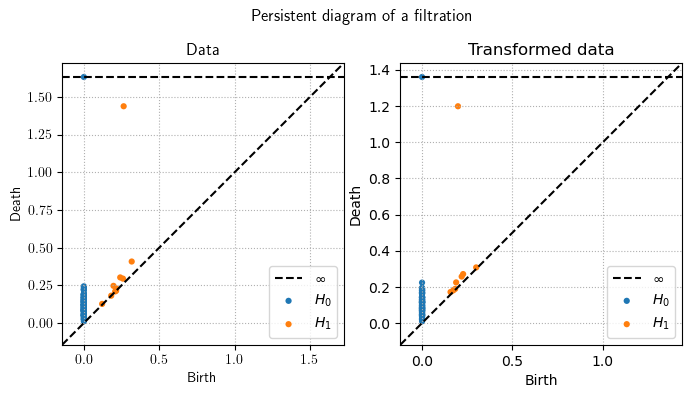

In [19]:
fig = plt.figure(figsize=(8,4))
plt.suptitle("Persistent diagram of a filtration")

plt.grid(linestyle="dotted")

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
vr.plot(diagram)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
vr.plot(diagram_transformed)

plt.show()

One can define the geometry on the space of persistent diagrams, defining a metric on it. Optimal transport approach is used to compare persistent diagrams which are multisets of intervals of arbitrary cardinality.  

The variants of optimal transport distances are _Wasserstein-2 distance_, and its approximations like _sliced Wasserstein distance_ and _Bollteneck distance_, which is Wasserstein-$\infty$ distance.

**Exercise**

Compute Bottleneck `persim.bottleneck` and sliced Wasserstein distances `persim.sliced_wasserstein` between perisistent diagrams of original and transformed data.

In [20]:
diagram

[array([[0.        , 0.01157155],
        [0.        , 0.0223635 ],
        [0.        , 0.02386812],
        [0.        , 0.02769828],
        [0.        , 0.03129444],
        [0.        , 0.03794352],
        [0.        , 0.04021288],
        [0.        , 0.04688038],
        [0.        , 0.04848427],
        [0.        , 0.04908972],
        [0.        , 0.05070714],
        [0.        , 0.05134012],
        [0.        , 0.05204555],
        [0.        , 0.05291053],
        [0.        , 0.05450629],
        [0.        , 0.05854703],
        [0.        , 0.06127206],
        [0.        , 0.06159086],
        [0.        , 0.06283159],
        [0.        , 0.06924886],
        [0.        , 0.07474917],
        [0.        , 0.07695965],
        [0.        , 0.07823333],
        [0.        , 0.07989119],
        [0.        , 0.07991057],
        [0.        , 0.08076152],
        [0.        , 0.08170909],
        [0.        , 0.08453318],
        [0.        , 0.08560967],
        [0.   

In [21]:
diagram[1].shape

(10, 2)

In [22]:
diagram_transformed[1].shape

(8, 2)

In [23]:
persim.bottleneck(diagram[1], diagram_transformed[1]) # pc w noise=0.1 vs w/ noise 0.12

0.2388620376586914

In [24]:
persim.sliced_wasserstein(diagram[1], diagram_transformed[1])

0.37242435007384694

Bottlneck distance used a single matching between most discriminative pair of points.

**Exercise**

Visualize Bottleneck matching.

In [25]:
# compute Bottleneck distance matching
d, matching = persim.bottleneck(diagram[1], diagram_transformed[1], matching=True)

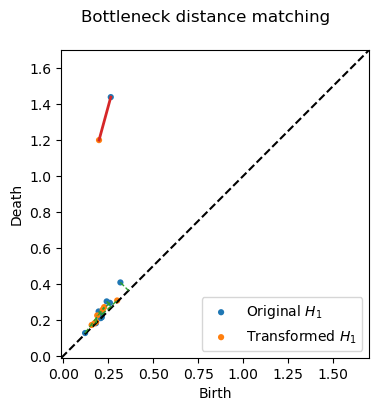

In [26]:
# plot Bottleneck distance matchign
fig = plt.figure(figsize=(8,4))
plt.suptitle("Bottleneck distance matching")
persim.bottleneck_matching(diagram[1], diagram_transformed[1], matching, labels=['Original $H_1$', 'Transformed $H_1$'])


For Bottleneck distance stability to small perturbations is theoretically proved.

**Exercise**

Plot Bottleneck distance with respect to different level of Gaussian noise applied to original data.

In [ ]:
# original data
X_orig, y = make_circles(n_samples=500, noise=0.0)
X_orig = X_orig
diagram_orig = vr.fit_transform(X_orig)

# your code here
dists = []

for noise in tqdm(np.arange(0, 0.26, 0.02)):
    # your code here
    X_noisy, _ = make_circles(n_samples=500, noise=noise)
    X_noisy = X_noisy
    
    diagram_noise = vr.fit_transform(X_noisy)
    
    dists.append(persim.bottleneck(diagram_orig[1], diagram_noise[1]))

In [ ]:
dists

In [ ]:
plt.plot(dists)

## 3. Persistent homology of graphs

Pipeline is as follows:

1. compute persistent diagrams via Ripser 
2. compute vectorization of diagrams, so-called persistent images and Betti curves
3. apply classifier on vectorization

In [27]:
# load data
X_graphs = pickle.load(open("./data/metric_graphs/X.pkl", "rb"))
y = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb"))
y_dnod = pickle.load(open("./data/metric_graphs/y_d_nod.pkl", "rb"))

y_col = ["a"] * len(y)
y_col = np.array(y_col)

y_col[y==0] = "blue"
y_col[y==2] = "green"
y_col[y==1] = "red"
y_col[y==3] = "yellow"

In [28]:
X_graphs

[array([[0.        , 0.33777989, 0.40137282, ..., 0.90804109, 0.94887688,
         0.87685797],
        [0.33777989, 0.        , 0.1729065 , ..., 0.83283229, 0.89014044,
         0.79696211],
        [0.40137282, 0.1729065 , 0.        , ..., 0.82727424, 0.87516303,
         0.78437776],
        ...,
        [0.90804109, 0.83283229, 0.82727424, ..., 0.        , 0.61007224,
         0.14655686],
        [0.94887688, 0.89014044, 0.87516303, ..., 0.61007224, 0.        ,
         0.8581059 ],
        [0.87685797, 0.79696211, 0.78437776, ..., 0.14655686, 0.8581059 ,
         0.        ]]),
 array([[0.        , 0.9479607 , 0.91939684, ..., 0.97779491, 0.89166747,
         0.9618493 ],
        [0.9479607 , 0.        , 0.53773747, ..., 0.99918399, 0.81423448,
         0.80060201],
        [0.91939684, 0.53773747, 0.        , ..., 0.99310897, 0.89106113,
         0.82315581],
        ...,
        [0.97779491, 0.99918399, 0.99310897, ..., 0.        , 0.41820733,
         0.74797515],
        [0.8

### Compute persistent diagrams

In [29]:
# add h_1 diagrams only
maxdim = 1
h = 1

rips = Rips(maxdim=maxdim)

diagrams = []
for x in X_graphs:
    diagrams.append(rips.fit_transform(x, distance_matrix=True)[h])

len(diagrams)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100

### Clusterization

In [30]:
%%time
n = len(X_graphs)
distances = np.zeros((n, n))

for i in range(0, n):
    for j in range(i+1, n):
        distances[i,j] = persim.sliced_wasserstein(diagrams[i], diagrams[j])
        
distances_symmetrize = distances + distances.T

CPU times: user 2min 22s, sys: 398 ms, total: 2min 23s
Wall time: 2min 24s


In [31]:
distances_symmetrize = distances + distances.T

In [32]:
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", random_state=1, n_jobs=-1)
X_metric = mds.fit(distances_symmetrize).embedding_

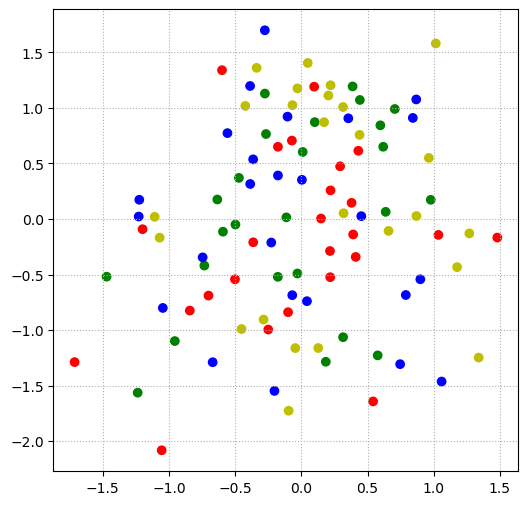

In [33]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_metric[:, 0], X_metric[:, 1], c=y_col)
plt.show()

### Vectorization

Persistent diagram is a multiset of intervals of arbitrary length which is can not be handled by methods of machine learning.

#### Persistent images

One possible to solutions besides providing a metric on the space of persistent diagrams is vectorization of diagrams to a vector of fixed length.

In [34]:
vietorisrips_tr = VietorisRipsPersistence(metric="precomputed")
diagrams_giotto = vietorisrips_tr.fit_transform(X_graphs)

In [35]:
pi = PersistenceImage(sigma=0.025, n_bins=64)
pimages = pi.fit_transform(diagrams_giotto)
pimages.shape

(100, 2, 64, 64)

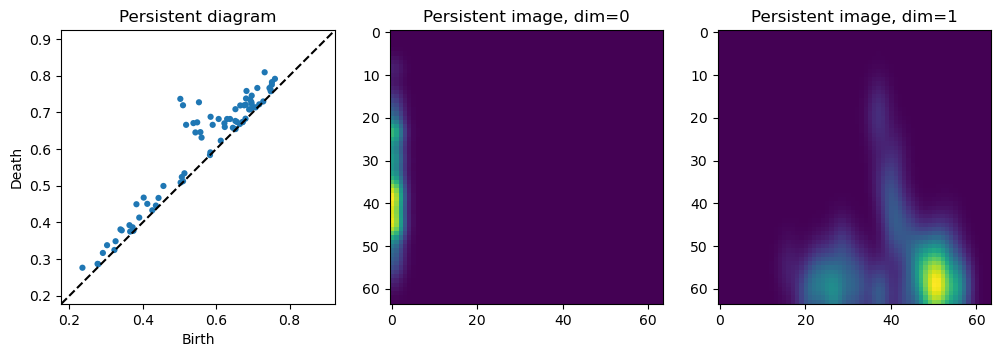

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

ax[0].set_title("Persistent diagram")
rips.plot(diagrams[0], legend=False, ax=ax[0])

ax[1].set_title("Persistent image, dim=0")
ax[1].imshow(pimages[0,0])

ax[2].set_title("Persistent image, dim=1")
ax[2].imshow(pimages[0,1])

plt.show()

### Classification

In [37]:
X_all = pimages[:,1].reshape((pimages[:,1].shape[0], -1))
y_all = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb")).astype(int)

X_control = X_all[y_all==0]
X_depression = X_all[y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

X.shape

(50, 4096)

In [38]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = LogisticRegression(penalty='l2', C=10.0, solver='liblinear', random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.6080 ± 0.1468


#### Betti curves

In [39]:
X_betti_curve = diagram2vec.persistence_curve(diagrams, m=32)
X_betti_curve.shape

(1, 100, 32)

In [40]:
X_betti_curve.shape

(1, 100, 32)

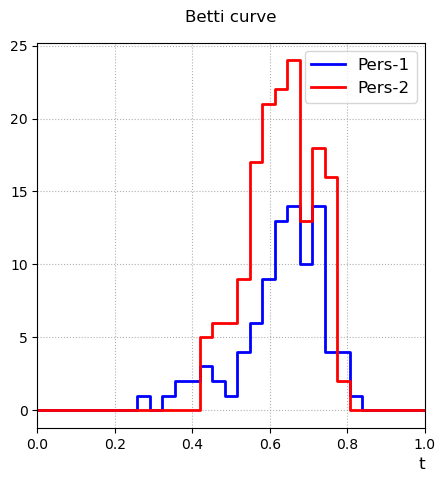

In [41]:
plt.figure(figsize=(5,5))
ax = plt.gca()
plt.xlim(0,1)
plt.title("Betti curve", pad=15)
plt.xlabel("t", fontsize=12, ha="right", x=1)
plt.ylabel("", ha="right", y=1)
plt.grid(linestyle="dotted")

plt.step(np.linspace(0,1,32), X_betti_curve[0,0], color="b", where="post", linewidth=2, label="Pers-1")
plt.step(np.linspace(0,1,32), X_betti_curve[0,1], color="r", where="post", linewidth=2, label="Pers-2")
plt.legend(fontsize=12)

plt.show()

In [42]:
X_control = X_betti_curve[0][y_all==0]
X_depression = X_betti_curve[0][y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [43]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.5240 ± 0.1106


## 4. Persistent homology of digital images

Persistence Diagrams with Linear Machine Learning Models (Obayashi, Hiraoka), 2017  
https://arxiv.org/abs/1706.10082

In [44]:
W = 300
sigma1 = 4
sigma2 = 2
t = 0.01

def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

### Image generation

Generate 100 images accoring to model A and model B

In [45]:
images = np.zeros((100,64,64))

# class A
N = 100
S = 30

for n in range(50):
    images[n] = generate(N, S)
    
# class B
N = 250
S = 10

for n in range(50):
    images[n+50] = generate(N, S)

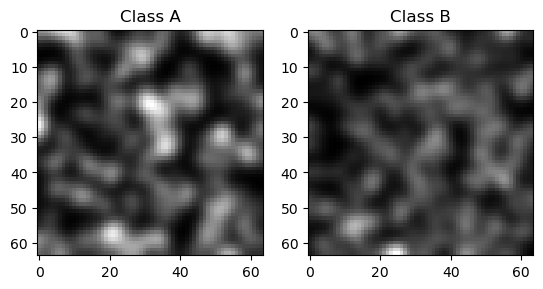

In [46]:
fig = plt.figure()
plt.gray()

ax1 = fig.add_subplot(121)
plt.title("Class A")

ax2 = fig.add_subplot(122)
plt.title("Class B")

ax1.imshow(images[int(np.random.uniform(0, 50))])
ax2.imshow(images[int(np.random.uniform(51, 100))])

plt.show()

### Compute persistent diagrams

In [47]:
diags = []

for i in range(images.shape[0]):
    diags.append(lower_star_img(images[i])[:-1])

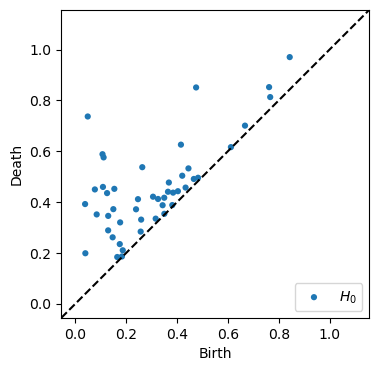

In [48]:
plt.figure(figsize=(4,4))
persim.plot_diagrams(diags[52])

### Vectorization

In [49]:
#pi = persim.PersImage(spread=0.04, pixels=[32, 32], verbose=False)
#pers_images = np.array(pi.transform(diags))

betti_curves = diagram2vec.persistence_curve(diags, m=25)

#pers_images.shape, betti_curves.shape

### Classification

#### Betti curves

In [50]:
X_betti_curves = betti_curves[0]
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

y_col = ["b"] * len(y)
y_col = np.array(y_col)

y_col[y==1] = "r"

In [51]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X_betti_curves, y):
    X_train, y_train = X_betti_curves[train_index], y[train_index]
    X_test, y_test = X_betti_curves[test_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.9260 ± 0.0550


### Clusterization

**Exercise**

Compute the two-dimensional embeddings using linear and nonlinear techniques learned during the course, given persistent images, Betti curves and pairwise distances between data points.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding

In [ ]:
X_emb = Isomap().fit_transform(X_betti_curves)

In [ ]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_col)
plt.show()

## 5. Deep sets

#### Problem
Persistence diagram is a multiset of vectors $D = \{(b_i, d_i, h_i)\}_{i=1}^N$ where $b_i$, $d_i$ are the birth and death times of $i$-th topological feature of dimension $h_i$. The classic approach to introduce persistent diagrams to machine learning is related to distances and kernels defined on the space of diagrams, which takes $O(n^2)$ time to compute. Vectrorization schemes such as persistence [images](https://arxiv.org/abs/1507.06217), [landscapes](https://arxiv.org/abs/1501.00179) or [curves](https://arxiv.org/abs/1904.07768) reduce the time to $O(n)$, yet all of this approaches are more or less fixed.

Trainable vectorization allows to learn vector representations of persistence diagrams, optimal w.r.t. the downstream task such as classification or regression. The simplest of such models, [Deep Sets](https://arxiv.org/abs/1703.06114) - $f: (\mathbb{R}^3)^N \rightarrow \mathbb{R}^d$

\begin{equation}
f(\{x_1, \dots, x_N\}) = \rho \left( \sum_{i=1}^N \phi(x_i) \right),
\end{equation}

consists of an encoder $\phi_\theta: \mathbb{R}^3 \rightarrow \mathbb{R}^D$ mapping each diagram point $x_i = (b_i, d_i, h_i)$, with parameters $\theta$ shared between points, a permutation invariant pooling operation $(\cdot): (\mathbb{R}^D)^N \rightarrow \mathbb{R}^D$ to obtain a representation of a diagram at whole (particulary for Deep Sets - sum pooling), and a decoder $\rho: \mathbb{R}^D \rightarrow \mathbb{R}^d$ which further transforms the diagram representation. It was [shown](https://arxiv.org/abs/1904.09378) that certain combinations of encoder/pooling/decoder correspond to the fixed representation schemes of persistence diagrams.

Deep sets encoder vectorizes each single point independently and does not consider the interdependence between points in the diagram. Thus, the self-attention block from the Transformer model which allows to capture those dependencies is a natural plug-in replacement to the encoder $\phi$.

\begin{equation}
\Phi_{ATTN}(\{x_1, \dots, x_N\}) = \left(\frac{(\mathbf{W}_q \mathbf{X})(\mathbf{W}_k \mathbf{X})^T}{\sqrt{D}} \right)\mathbf{W}_v\mathbf{X},
\end{equation}

where $\Phi_{ATTN}: (\mathbb{R}^3)^N \rightarrow (\mathbb{R}^D)^N$.

In [ ]:
def generate_orbit(point_0, r, n=300):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=300, random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j])
            
    return orbits

In [ ]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, random_state=random_state)

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6), dpi=200)
for i in range(2):
    for j in range(5):
        if i==0:
            ax[i,j].set_title("Class {}".format(j+1))
        ax[i,j].scatter(X_orbit5k[j*1000+i,:,0], X_orbit5k[j*1000+i,:,1], s=10)

In [ ]:
X_pc = np.concatenate((X_orbit5k[2000:3000], X_orbit5k[4000:5000]))
y = np.concatenate((np.zeros(1000), np.ones(1000)))

In [ ]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

In [ ]:
X = []

for x_pc in tqdm(X_pc):
    diagram = conv_pd(vr.fit_transform(x_pc))
    X.append(diagram)

#### Dataset 

In [ ]:
class Orbit2kDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_fn(data):
    
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
    
    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

#### Model

In [ ]:
class DeepSets(torch.nn.Module):
    def __init__(self, n_in, n_hidden_enc, n_out_enc, n_hidden_dec=16, n_out_dec=2):
        super(DeepSets, self).__init__()
        self.encoder = Encoder(n_in, n_hidden_enc, n_out_enc)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        z_enc = self.encoder(X)
        z = self.decoder(z_enc)
        return z
    
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(MLP, self).__init__()
        self.linear1 = Linear(n_in, n_hidden)
        self.linear2 = Linear(n_hidden, n_out)
        
    def forward(self, X):
        X = relu(self.linear1(X))
        X = self.linear2(X)
        return X
    
class Encoder(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(Encoder, self).__init__()
        self.mlp = MLP(n_in, n_hidden, n_out)
        
    def forward(self, X):
        X = self.mlp(X)
        x = X.mean(dim=1) # aggregation
        return x

#### Train

In [ ]:
%%time
n_repeats = 3
n_epochs = 100
batch_size = 32
lr = 0.0005

n_train, n_test = 1600, 400

history = np.zeros((n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit2kDataset(X, y)

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # model init
    model = DeepSets(n_in=3, n_hidden_enc=32, n_out_enc=16)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        model.train()
        
        loss_epoch = []
        for batch in dataloader_train:
            loss_batch = criterion(model(batch[0]), batch[1])
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch.append(loss_batch.detach())
        
        loss_epoch_mean = np.array(loss_epoch).mean()
        history[repeat_idx,epoch_idx,0] = loss_epoch_mean
        
        # test
        model.eval()
        
        correct = 0
        for batch in dataloader_train:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_train = correct / len(dataloader_train.dataset)
        history[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        for batch in dataloader_test:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_test = correct / len(dataloader_test.dataset)
        history[repeat_idx,epoch_idx,2] = accuracy_test
        
        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

In [ ]:
x = np.arange(n_epochs)
loss_ci1 = history.mean(axis=0)[:,0] - history.std(axis=0)[:,0]
loss_ci2 = history.mean(axis=0)[:,0] + history.std(axis=0)[:,0]
acc_train_ci1 = history.mean(axis=0)[:,1] - history.std(axis=0)[:,1]
acc_train_ci2 = history.mean(axis=0)[:,1] + history.std(axis=0)[:,1]
acc_test_ci1 = history.mean(axis=0)[:,2] - history.std(axis=0)[:,2]
acc_test_ci2 = history.mean(axis=0)[:,2] + history.std(axis=0)[:,2]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams", fontsize=14)
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_ylim(0.58, 0.7)
ax[1].set_ylim(0.45, 0.75)
ax[0].plot(history.mean(axis=0)[:,0], c="g")
ax[0].fill_between(x, loss_ci1, loss_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:,1], c="r", label="Train")
ax[1].plot(history.mean(axis=0)[:,2], c="b", label="Test")
ax[1].fill_between(x, acc_train_ci1, acc_train_ci2, color="r", alpha=0.1)
ax[1].fill_between(x, acc_test_ci1, acc_test_ci2, color="b", alpha=0.1)
ax[1].legend(loc=4)
plt.show()